In [4]:
# Cargar el diccionario del json para los multiplicadores de la tabla de tipos
# typeMult['attack_type']['defensive_type']
import json
with open('type-chart.json') as file:
    typeMult = json.load(file)
types = typeMult.keys()


import pypokedex as dex
import math
import queue as q

## ESTADISTICAS INDIVIDUALES ##
import pypokedex as dex
import math

def atkScore(pokemon: dex.Pokemon, t_def:str) -> float:
    atk = pokemon.base_stats.attack
    types_atk = pokemon.types

    if len(pokemon.types)<2:
        t_atk = types_atk[0]
        score = atk * typeMult[t_atk][t_def]
    else:
        t1_atk, t2_atk = types_atk
        score = max(typeMult[t1_atk][t_def], typeMult[t2_atk][t_def]) * atk
    
    return score

def spAtkScore(pokemon: dex.Pokemon, t_def:str) -> float:
    atk = pokemon.base_stats.sp_atk
    types_atk = pokemon.types

    if len(pokemon.types)<2:
        t_atk = types_atk[0]
        score = atk * typeMult[t_atk][t_def]
    else:
        t1_atk, t2_atk = types_atk
        score = max(typeMult[t1_atk][t_def], typeMult[t2_atk][t_def]) * atk

    return score


def defScore(pokemon: dex.Pokemon, t_atk:str) -> float:
    defe = pokemon.base_stats.defense
    hp = pokemon.base_stats.hp
    types_def = pokemon.types

    if len(pokemon.types)<2:
        t_def = types_def[0]
        score = math.sqrt(defe*hp) / typeMult[t_atk][t_def]
    else:
        t1_def, t2_def = types_def
        score = math.sqrt(defe*hp) / (typeMult[t_atk][t1_def] * typeMult[t_atk][t2_def])
    
    return score

def spDefScore(pokemon: dex.Pokemon, t_atk:str) -> float:
    defe = pokemon.base_stats.sp_def
    hp = pokemon.base_stats.hp
    types_def = pokemon.types

    if len(pokemon.types)<2:
        t_def = types_def[0]
        score = math.sqrt(defe*hp) / typeMult[t_atk][t_def]
    else:
        t1_def, t2_def = types_def
        score = math.sqrt(defe*hp) / (typeMult[t_atk][t1_def] * typeMult[t_atk][t2_def])

    return score



## FITNESS GLOBAL ##
import queue as q
def teamScore(team: list[int]) -> float:
    score = 0.0
    minq_vel = q.PriorityQueue()

    T = len(types)
    invT = 1/T

    minq_atkScores:list[q.PriorityQueue] = [q.PriorityQueue() for _ in range(T)]
    minq_spAtkScores:list[q.PriorityQueue] = [q.PriorityQueue() for _ in range(T)]
    minq_defScores:list[q.PriorityQueue] = [q.PriorityQueue() for _ in range(T)]
    minq_spDefScores:list[q.PriorityQueue] = [q.PriorityQueue() for _ in range(T)]

    
    for pokemon_id in team:
        pokemon = dex.get(dex=pokemon_id)

        i=0
        for type in types:
            minq_atkScores[i].put(atkScore(pokemon, type)); minq_spAtkScores[i].put(spAtkScore(pokemon, type))
            minq_defScores[i].put(defScore(pokemon, type)); minq_spDefScores[i].put(spDefScore(pokemon, type))
            i+=1
        minq_vel.put(pokemon.base_stats.speed)

    for rank in range(len(team), 0, -1):
        score_this_rank = 0.0
        for i in range(0,T):
            score_this_rank += (minq_atkScores[i].get() + minq_spAtkScores[i].get() + minq_defScores[i].get() + minq_spDefScores[i].get()) * invT
        score_this_rank *= invT
        score_this_rank += minq_vel.get()/rank/rank
        score_this_rank /= rank
        score += score_this_rank
    return score


## MOSTRAR INFORMACIÓN SOBRE EL EQUIPO
import pypokedex
from io import BytesIO
from IPython.display import display, HTML
import base64
import matplotlib.pyplot as plt

def showTeam (pokemons_ids):

    print(f"teamScore = {teamScore(pokemons_ids)}")


    # Mostrar la información en una tabla
    html = ''' 
    <table border='1'>
        <tr>
            <th>#ID</th>
            <th>Imagen</th>
            <th>Nombre</th>
            <th>Tipo</th>
            <th>Estadísticas </th>
            <th>Atacando frente a tipos</th>
            <th>Defendiendo frente a tipos </th>
        </tr> 
    '''

    # Función para mapear el valor de la estadística a un color
    def get_color(value):
        if value <= 100:
            r = int(255 * (1 - value / 100))
            g = int(255 * (value / 100))
            b = 0
        else:
            r = 0
            g = 255 #int(255 * (1 - (value - 100) / 155))
            b = int(255 * ((value - 100) / 155) * 1.5)
            if b > 255:
                b = 255  # Asegurarse de que el valor no exceda 255
        return f'#{r:02x}{g:02x}{b:02x}'

    # Obtener la información de los Pokémon
    for pokemon_id in pokemons_ids:
        pokemon = pypokedex.get(dex=pokemon_id)
        image_url = pokemon.sprites.front.get('default')
        stats = pokemon.base_stats

        # Crear el gráfico de barras con las estadísticas
        values = [stats.hp, stats.attack, stats.defense, stats.sp_atk, stats.sp_def, stats.speed]
        colors = [get_color(value) for value in values]
        fig, ax = plt.subplots()
        ax.bar(['HP', 'Atk', 'Def', 'Sp.Atk', 'Sp.Def', 'Speed'], values, color=colors)
        
        # Guardar el gráfico como imagen en memoria
        buf = BytesIO()
        plt.savefig(buf, format='png')
        plt.close(fig)
        buf.seek(0)
        img_base64 = base64.b64encode(buf.read()).decode('utf-8')

        # Obtener tabla de tipos de ataque
        good_attacking = []
        bad_attacking = []

        for my_type in pokemon.types:
            for other_type in types:
                if typeMult[my_type][other_type] == 2:
                    good_attacking.append(other_type)
                elif typeMult[my_type][other_type] == 0.5:
                    bad_attacking.append(other_type)

        bad_attacking = [item for item in bad_attacking if item not in good_attacking]
        
        # Obtener tabla de tipos defendiendo
        very_good_defending = []
        good_defending = []
        neutral_defending = []
        bad_defending = []
        very_bad_defending = []

        arrayByMult = {
            25: very_good_defending,
            50: good_defending,
            100: neutral_defending,
            200: bad_defending,
            400: very_bad_defending
        }

        for other_type in types:
            mult1 = typeMult[other_type][pokemon.types[0]]
            mult2 = 1 if len(pokemon.types)<2 else typeMult[other_type][pokemon.types[1]]
            arrayByMult[int(mult1*mult2*100)].append(other_type)

        # Imprimir tabla con la información previamente recopilada
        html += "<tr>"
        html += f"<td>#{pokemon_id}</td>"
        html += f"<td><img src='{image_url}' width='150'></td>"
        html += f"<td><b>{pokemon.name.capitalize()}</b></td>"
        html += f"<td>{pokemon.types}</td>"
        html += f"<td><img src='data:image/png;base64,{img_base64}' width='300'></td>"
        html += f"<td>x2: {good_attacking}<br>x0.5: {bad_attacking}</td>"
        html += f"<td>/4: {very_good_defending}<br>/2: {good_defending}<br>/0.5: {bad_defending} <br>/0.25: {very_bad_defending}</td>"
        html += "</tr>"

    html += "</table>"

    display(HTML(html))

    





from dataclasses import dataclass
from typing import Dict

def teamScore(team: list[int]) -> float:
    score = 0.0
    minq_vel = q.PriorityQueue()

    T = len(types)
    invT = 1/T

    minq_atkScores:list[q.PriorityQueue] = [q.PriorityQueue() for _ in range(T)]
    minq_spAtkScores:list[q.PriorityQueue] = [q.PriorityQueue() for _ in range(T)]
    minq_defScores:list[q.PriorityQueue] = [q.PriorityQueue() for _ in range(T)]
    minq_spDefScores:list[q.PriorityQueue] = [q.PriorityQueue() for _ in range(T)]

    
    for pokemon_id in team:

        i=0
        for i in range(0,T):
            minq_atkScores[i].put(atkScoreP(pokemon_id, i)); minq_spAtkScores[i].put(spAtkScoreP(pokemon_id, i))
            minq_defScores[i].put(defScoreP(pokemon_id, i)); minq_spDefScores[i].put(spDefScoreP(pokemon_id, i))
            i+=1
        minq_vel.put(velP(pokemon_id))

    for rank in range(len(team), 0, -1):
        score_this_rank = 0.0
        for i in range(0,T):
            score_this_rank += (minq_atkScores[i].get() + minq_spAtkScores[i].get() + minq_defScores[i].get() + minq_spDefScores[i].get()) * invT
        score_this_rank *= invT
        score_this_rank += minq_vel.get()/rank/rank
        score_this_rank /= rank
        score += score_this_rank

    return score


@dataclass
class IndStats:
    atk: list[float]
    defe: list[float]
    spAtk: list[float]
    spDef: list[float]
    vel: float


def precalcAll(D):
    global precalc

    precalc = ["no existe id 0"]
    
    for pokemon_id in range(1,D):
        print(pokemon_id)
        pokemon = pypokedex.get(dex=pokemon_id)

        atk=[]
        defe=[]
        spAtk=[]
        spDef=[]

        for type in types:
            atk.append(atkScore(pokemon, type))
            defe.append(defScore(pokemon, type))
            spAtk.append(defScore(pokemon, type))
            spDef.append(spDefScore(pokemon, type))

        precalc.append(IndStats(
            atk=atk,
            defe=defe,
            spAtk=spAtk,
            spDef=spDef,
            vel=pokemon.base_stats.speed
        ))



def atkScoreP(pokemon_id, type_id):
    global precalc
    return precalc[pokemon_id].atk[type_id]

def defScoreP(pokemon_id, type_id):
    global precalc
    return precalc[pokemon_id].defe[type_id]

def spAtkScoreP(pokemon_id, type_id):
    global precalc
    return precalc[pokemon_id].spAtk[type_id]

def spDefScoreP(pokemon_id, type_id):
    global precalc
    return precalc[pokemon_id].spDef[type_id]
    
def velP(pokemon_id):
    global precalc
    return precalc[pokemon_id].vel

In [7]:
precalcAll(1023)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


PyPokedexError: An internal requests exception occurred!

In [9]:
# A veces se corta las consultas si son muy rápidas
# esta función es para que continue precalculando
def continue_precalc(D):
    global precalc

    for pokemon_id in range(len(precalc),D):
        print(pokemon_id)
        pokemon = pypokedex.get(dex=pokemon_id)

        atk=[]
        defe=[]
        spAtk=[]
        spDef=[]

        for type in types:
            atk.append(atkScore(pokemon, type))
            defe.append(defScore(pokemon, type))
            spAtk.append(defScore(pokemon, type))
            spDef.append(spDefScore(pokemon, type))

        precalc.append(IndStats(
            atk=atk,
            defe=defe,
            spAtk=spAtk,
            spDef=spDef,
            vel=pokemon.base_stats.speed
        ))

continue_precalc(D)

599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848


In [10]:
def pareto_frontier():
    global precalc
    global pareto_pokemon

    """
    Obtiene los individuos que están en la frontera de Pareto o por encima en K dimensiones para puntuajes de Pokémon.
    
    Args:
    pokemons (list of Pokemon): Lista de objetos Pokémon.
    
    Returns:
    list of Pokemon: Lista de Pokémon que están en la frontera de Pareto o por encima.
    """
    # Convertir la lista de Pokémon a una lista de puntos
    points = []
    for p in precalc[1:]:
        point = [p.vel]
        point.extend(p.atk)
        point.extend(p.spAtk)
        point.extend(p.defe)
        point.extend(p.spDef)
        points.append(point)
    
    # Inicializar la lista de puntos en la frontera de Pareto
    pareto_front = []
    
    # Iterar sobre cada punto
    for i, point in enumerate(points):
        print(i)
        # Asumir que el punto está en la frontera de Pareto
        is_pareto = True
        for j, other_point in enumerate(points):
            if i != j:
                # Si otro punto domina al punto actual, no está en la frontera de Pareto
                if all(o >= p for o, p in zip(other_point, point)) and any(o > p for o, p in zip(other_point, point)):
                    is_pareto = False
                    break
        if is_pareto:
            pareto_front.append(point)
    
    return pareto_front

pareto_front = pareto_frontier()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [11]:
def filtrate(pareto_front):
    global pareto_dex
    global precalc

    pareto_dex = []

    for i in range(1, len(precalc)):
        pc = precalc[i]
        point = [pc.vel]
        point.extend(pc.atk)
        point.extend(pc.spAtk)
        point.extend(pc.defe)
        point.extend(pc.spDef)

        if not is_dominated(point, pareto_front):
            pareto_dex.append(i)

        

def is_dominated(point, pareto_front):
    for pareto_point in pareto_front:
        if all(p >= pt for p, pt in zip(pareto_point, point)) and any(p > pt for p, pt in zip(pareto_point, point)):
             return True
    return False


filtrate(pareto_front)

In [14]:
## MÉTODOS DEFINIDOS ##
import random
import datetime

def get_new_team(team: list[int]) -> list[int]:
    raise NotImplemented

def stop_condition(max_iter: int, temp: float) -> bool:
    raise NotImplemented

def update_temp(temp: float) -> float:
    raise NotImplemented


# get_new_team
mutation_rate = 1/6
def new_mutated_team(team: list[int]) -> list[int]:
    global D
    global mutation_rate
    global pareto_dex

    new_team = team.copy()
    for i in range(len(new_team)):
        if random.uniform(0,1) < mutation_rate:
            new_team[i] = random.choice(pareto_dex)
    
    return new_team

# stop_condition
max_iter = 1000
min_temp = 0
def stop_iter_or_cooling(iterations: int, temp: int) -> bool:
    global min_temp
    global max_iter

    return iterations < max_iter and temp > min_temp

# update_temp
delta_temp = 10**(-3)
def update_lineal(temp: float) -> float:
    global delta_temp
    return temp - delta_temp

cooling_rate = 0.9
def exponential_update(temp:float) -> float:
    print(temp)
    global cooling_rate
    return cooling_rate*temp




## CLASE DE EXPERIMENTO ##

class Experiment:
    def __init__(self):
        self.teams = []
        self.scores = []
        self.times = []
        self.iterations = []
        self.temps = []
    
    def add(self, temp) -> None:
        global best_score
        global best_team
        global time_start
        global iterations

        if not self.scores or self.scores[-1]<best_score:
            self.teams.append(best_team[:])
            self.scores.append(best_score)
            self.times.append((datetime.datetime.now() - time_start).total_seconds()) 
            self.iterations.append(iterations)
            self.temps.append(temp)
    
    def showTable(self) -> None:
        table_html = "<table><tr><th>Teams</th><th>Scores</th><th>Times</th><th>Iterations</th><th>Temperatures</th></tr>"
        for team, score, time, iteration, temp in zip(self.teams, self.scores, self.times, self.iterations, self.temps):
            team_images = ''.join([f'<img src="https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/{pokemon_id}.png" width="50" height="50">' for pokemon_id in team])
            table_html += f"<tr><td>{team_images}</td><td>{score}</td><td>{time}</td><td>{iteration}</td><td>{temp}</td></tr>"
        table_html += "</table>"
        display(HTML(table_html))


## ALGORITMO COMPLETO ##

def run_simulated_annealing(team: list[int], max_iter: int, temp: float) -> Experiment:

    global best_team
    best_team = team

    global best_score
    best_score = teamScore(team)

    global time_start
    time_start = datetime.datetime.now()

    experiment = Experiment()

    global iterations
    iterations = 0

    while stop_condition(iterations, temp):

        new_team = get_new_team(team)

        current_score = teamScore(team)
        new_score = teamScore(new_team)
        delta_score = new_score - current_score

        if delta_score > 0:
            team = new_team

            if new_score > best_score:
                best_score = new_score
                best_team = new_team
        
        else:
            p = math.exp(delta_score / temp)
            r = random.uniform(0, 1)
            team = new_team if r < p else team

        experiment.add(temp)

        temp = update_temp(temp)
        iterations += 1

    return experiment

In [15]:
N=100
D=1024

get_new_team = new_mutated_team
mutation_rate = 1/95

stop_condition = stop_iter_or_cooling
min_temp = 10**(-14) #-20
max_iter = 10**(7)

update_temp = exponential_update
cooling_rate = .995

experiment1 = run_simulated_annealing([1 for _ in range(100)], max_iter=999999999, temp=1000)

1000
995.0
990.025
985.074875
980.149500625
975.248753121875
970.3725093562656
965.5206468094842
960.6930435754368
955.8895783575597
951.1101304657719
946.354579813443
941.6228069143758
936.914692879804
932.2301194154049
927.5689688183279
922.9311239742362
918.316468354365
913.7248860125932
909.1562615825302
904.6104802746175
900.0874278732445
895.5869907338782
891.1090557802088
886.6535105013078
882.2202429488012
877.8091417340572
873.4200960253869
869.0529955452599
864.7077305675336
860.384191914696
856.0822709551225
851.8018596003468
847.5428503023451
843.3051360508333
839.0886103705791
834.8931673187262
830.7187014821326
826.565107974722
822.4322824348484
818.3201210226741
814.2285204175607
810.157377815473
806.1065909263956
802.0760579717636
798.0656776819047
794.0753492934952
790.1049725470277
786.1544476842926
782.2236754458711
778.3125570686417
774.4209942832985
770.5488893118819
766.6961448653225
762.8626641409959
759.0483508202909
755.2531090661895
751.4768435208586
747.71945

Text(0, 0.5, 'fitness')

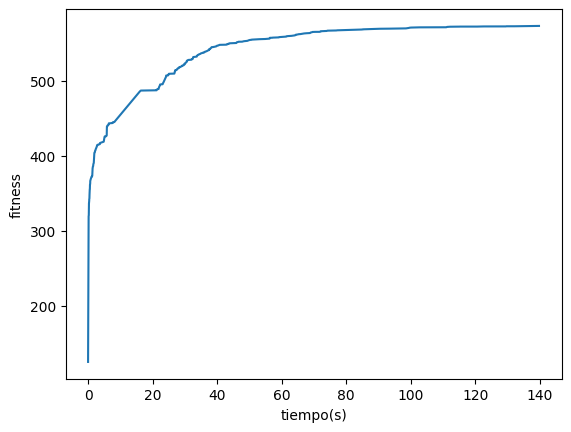

In [19]:
import matplotlib.pyplot as plt
plt.plot(experiment1.times, experiment1.scores)
plt.xlabel('tiempo(s)')
plt.ylabel('fitness')

In [21]:
best_score

573.6151205572479

In [23]:
N=1000
D=1024

get_new_team = new_mutated_team
mutation_rate = 1/940

stop_condition = stop_iter_or_cooling
min_temp = 10**(-14) #-20
max_iter = 10**(7)

update_temp = exponential_update
cooling_rate = .995

experiment1k = run_simulated_annealing([1 for _ in range(1000)], max_iter=999999999, temp=1000)

1000
995.0
990.025
985.074875
980.149500625
975.248753121875
970.3725093562656
965.5206468094842
960.6930435754368
955.8895783575597
951.1101304657719
946.354579813443
941.6228069143758
936.914692879804
932.2301194154049
927.5689688183279
922.9311239742362
918.316468354365
913.7248860125932
909.1562615825302
904.6104802746175
900.0874278732445
895.5869907338782
891.1090557802088
886.6535105013078
882.2202429488012
877.8091417340572
873.4200960253869
869.0529955452599
864.7077305675336
860.384191914696
856.0822709551225
851.8018596003468
847.5428503023451
843.3051360508333
839.0886103705791
834.8931673187262
830.7187014821326
826.565107974722
822.4322824348484
818.3201210226741
814.2285204175607
810.157377815473
806.1065909263956
802.0760579717636
798.0656776819047
794.0753492934952
790.1049725470277
786.1544476842926
782.2236754458711
778.3125570686417
774.4209942832985
770.5488893118819
766.6961448653225
762.8626641409959
759.0483508202909
755.2531090661895
751.4768435208586
747.71945

Text(0, 0.5, 'fitness')

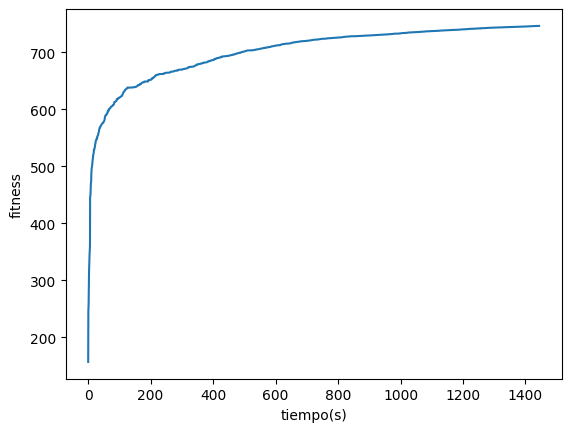

In [24]:
import matplotlib.pyplot as plt
plt.plot(experiment1k.times, experiment1k.scores)
plt.xlabel('tiempo(s)')
plt.ylabel('fitness')

In [25]:
best_score

746.6330575166849